In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import yfinance as yf
from datetime import datetime

In [3]:
btc = yf.download('BTC-USD', start='2020-01-01', end='2024-07-26')


[*********************100%%**********************]  1 of 1 completed


## 技術指標因子函數算法

In [5]:
# Bollinger Bands
btc['Middle Band'] = btc['Close'].rolling(window=20).mean()
btc['Upper Band'] = btc['Middle Band'] + (btc['Close'].rolling(window=20).std() * 2)
btc['Lower Band'] = btc['Middle Band'] - (btc['Close'].rolling(window=20).std() * 2)

# RSI
delta = btc['Close'].diff()
gain = (delta.where(delta > 0, 0)).rolling(window=30).mean()
loss = (-delta.where(delta < 0, 0)).rolling(window=30).mean()
rs = gain / loss
btc['RSI'] = 100 - (100 / (1 + rs))

# EMA
btc['EMA1'] = btc['Close'].ewm(span=12).mean()
btc['EMA2'] = btc['Close'].ewm(span=26).mean()

# ATR
btc['最高-最低'] = btc['High'] - btc['Low']
btc['最高-前收盤'] = np.abs(btc['High'] - btc['Close'].shift(1))
btc['最低-前收盤'] = np.abs(btc['Low'] - btc['Close'].shift(1))
btc['真實範圍'] = btc[['最高-最低', '最高-前收盤', '最低-前收盤']].max(axis=1)
btc['ATR'] = btc['真實範圍'].rolling(window=20).mean()

# ADX
btc['上升動向'] = btc['High'] - btc['High'].shift(1)
btc['下降動向'] = btc['Low'].shift(1) - btc['Low']
btc['正DI'] = np.where((btc['上升動向'] > btc['下降動向']) & (btc['上升動向'] > 0), btc['上升動向'], 0)
btc['負DI'] = np.where((btc['下降動向'] > btc['上升動向']) & (btc['下降動向'] > 0), btc['下降動向'], 0)
btc['+DI'] = 100 * (btc['正DI'].ewm(span=12, adjust=False).mean() / btc['ATR'])
btc['-DI'] = 100 * (btc['負DI'].ewm(span=12, adjust=False).mean() / btc['ATR'])
btc['DX'] = 100 * np.abs((btc['+DI'] - btc['-DI']) / (btc['+DI'] + btc['-DI']))
btc['ADX'] = btc['DX'].ewm(span=12, adjust=False).mean()

# CCI
btc['典型價格'] = (btc['High'] + btc['Low'] + btc['Close']) / 3
btc['TP均線'] = btc['典型價格'].rolling(window=20).mean()
btc['平均偏差'] = btc['典型價格'].rolling(window=20).apply(lambda x: np.mean(np.abs(x - np.mean(x))))
btc['CCI'] = (btc['典型價格'] - btc['TP均線']) / (0.015 * btc['平均偏差'])

# Return
btc['Return']=btc['Close']/btc['Close'].shift(1)-1

## 交易訊號定義

In [6]:
# Bollinger Bands
btc['Bollinger_Buy'] = np.where(btc['Close'] < btc['Lower Band'], 1, 0)
btc['Bollinger_Sell'] = np.where(btc['Close'] > btc['Upper Band'], 1, 0)
btc['Bollinger_Strategy']= np.where(btc['Close'] < btc['Lower Band'], 1, -1)

# RSI
btc['RSI_Buy'] = np.where(btc['RSI'] < 30, 1, 0)
btc['RSI_Sell'] = np.where(btc['RSI'] > 70, 1, 0)
btc['RSI_Strategy'] = np.where(btc['RSI'] < 30, 1, np.where(btc['RSI'] > 70, -1, 0))

# EMA
btc['EMA_Buy'] = np.where(btc['EMA1']>btc['EMA2'], 1,0)
btc['EMA_Sell'] = np.where(btc['EMA1']<btc['EMA2'],1 ,0)
btc['EMA_Strategy'] = np.where(btc['EMA1'] > btc['EMA2'], 1, -1)

# ADX
btc['ADX_Buy'] = np.where((btc['+DI'] > btc['-DI']) & (btc['ADX'] > 25), 1, 0)
btc['ADX_Sell'] = np.where((btc['-DI'] > btc['+DI']) & (btc['ADX'] > 25), 1, 0)
btc['ADX_Strategy']= np.where((btc['+DI'] > btc['-DI']) & (btc['ADX'] > 25), 1, -1)

# CCI
btc['CCI_Buy'] = np.where(btc['CCI'] < -100, 1, 0)
btc['CCI_Sell'] = np.where(btc['CCI'] > 100, 1, 0)
btc['CCI_Strategy'] = np.where(btc['CCI'] < -100, 1, np.where(btc['CCI']>100,-1,0))



## 價量因子回測

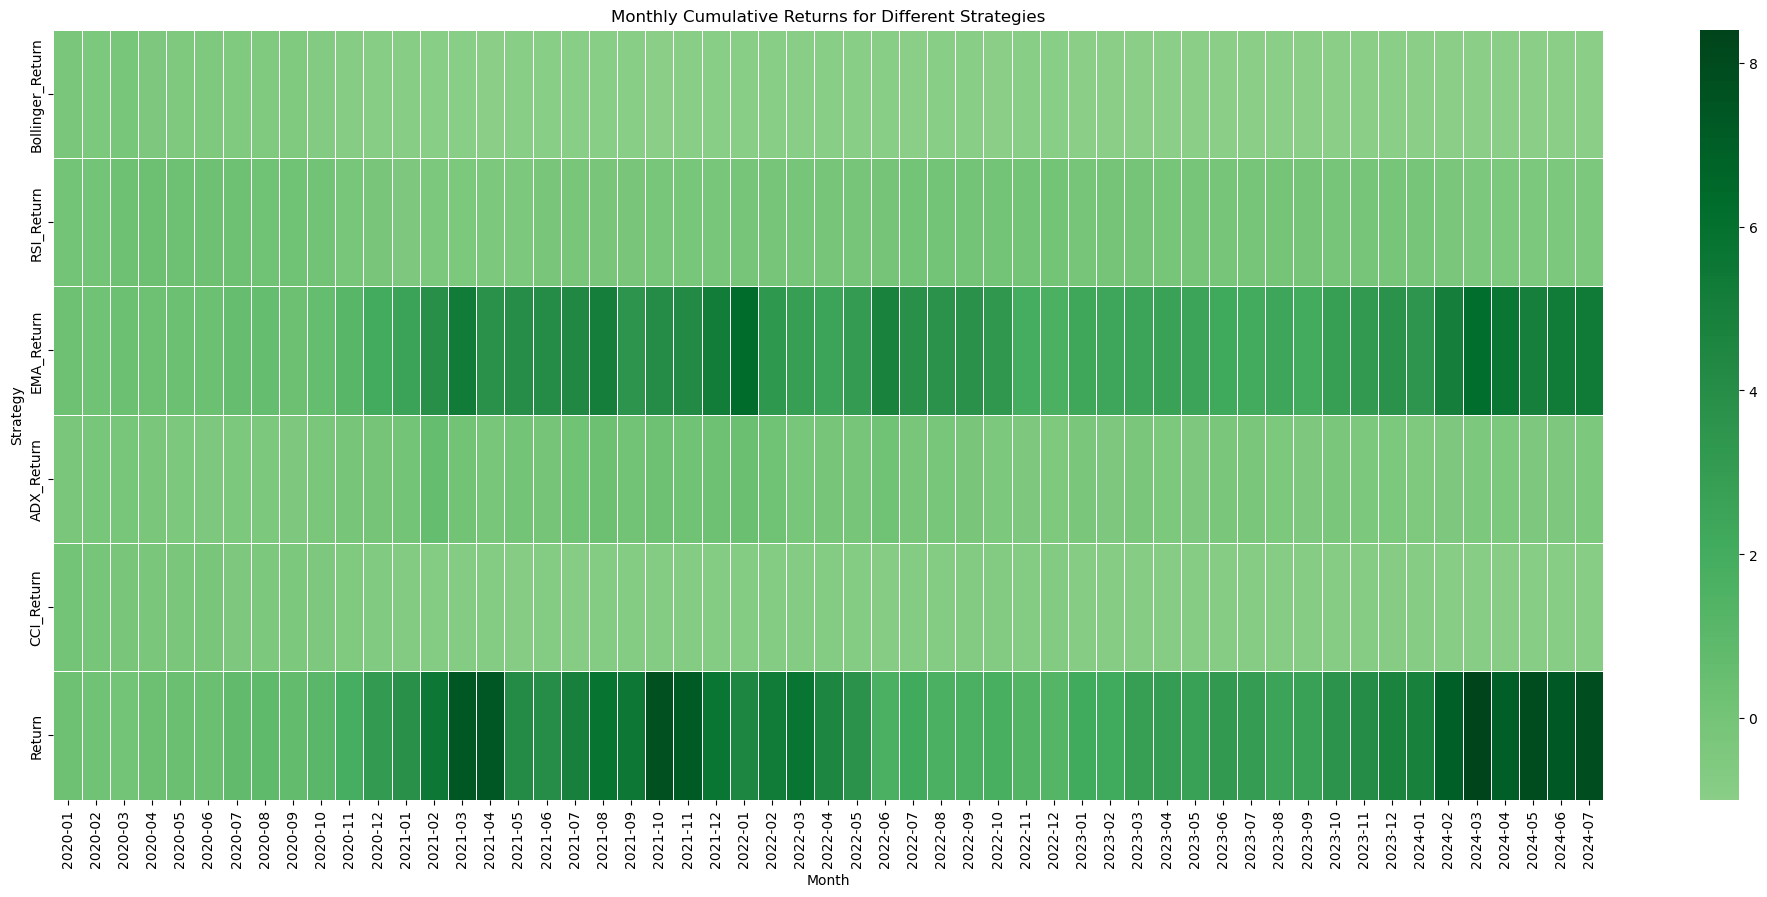

In [8]:
# 計算每個策略的每日回報率
btc['Bollinger_Return'] = btc['Bollinger_Strategy'].shift(1) * btc['Return']
btc['RSI_Return'] = btc['RSI_Strategy'].shift(1) * btc['Return']
btc['EMA_Return'] = btc['EMA_Strategy'].shift(1) * btc['Return']
btc['ADX_Return'] = btc['ADX_Strategy'].shift(1) * btc['Return']
btc['CCI_Return'] = btc['CCI_Strategy'].shift(1) * btc['Return']

# 將日期設置為索引
btc['Date'] = btc.index

# 將數據按月分組並計算每月回報率
monthly_returns = btc.resample('M', on='Date').sum()

# 創建包含所有策略的 DataFrame
strategies = ['Bollinger_Return', 'RSI_Return', 'EMA_Return', 'ADX_Return', 'CCI_Return','Return']
monthly_returns = monthly_returns[strategies]

# 計算每月的總回報率
monthly_returns_cumulative = (1 + monthly_returns).cumprod() - 1

# 將月度索引格式化為年-月
monthly_returns_cumulative.index = monthly_returns_cumulative.index.to_period('M').strftime('%Y-%m')

# 繪製矩陣熱圖
plt.figure(figsize=(25, 10))
sns.heatmap(monthly_returns_cumulative.T, annot=False, fmt=".2%",cmap='Greens', center=0, linewidths=.5) #'RdYlGn'
plt.title('Monthly Cumulative Returns for Different Strategies')
plt.xlabel('Month')
plt.ylabel('Strategy')
plt.show();

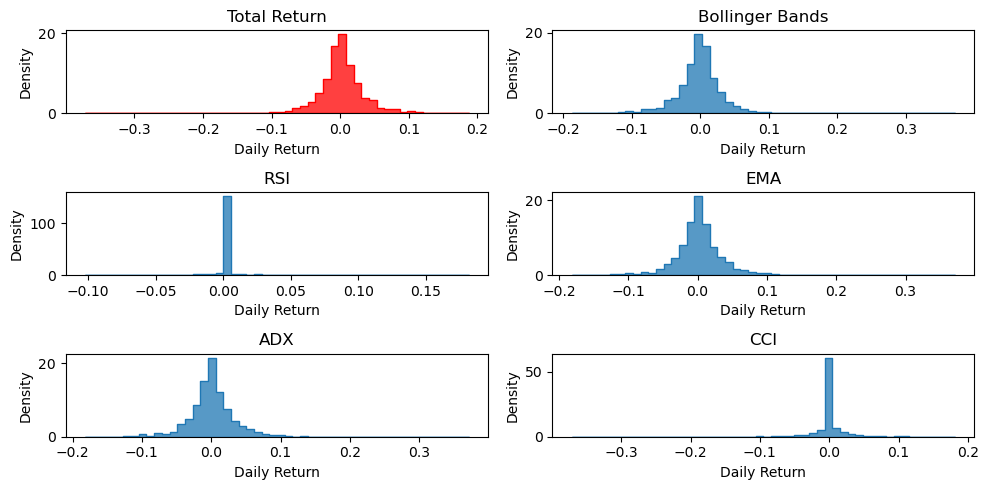

In [9]:
# 繪製日報酬率的直方圖
fig, axes = plt.subplots(3, 2, figsize=(10, 5));

sns.histplot(btc['Return'].dropna(), kde=False, stat="density", bins=50, element='step', ax=axes[0, 0], color='r')
axes[0, 0].set_title('Total Return')
axes[0, 0].set_xlabel('Daily Return')
axes[0, 0].set_ylabel('Density')

sns.histplot(btc['Bollinger_Return'].dropna(), kde=False, stat="density", bins=50, element='step', ax=axes[0, 1])
axes[0, 1].set_title('Bollinger Bands')
axes[0, 1].set_xlabel('Daily Return')
axes[0, 1].set_ylabel('Density')

sns.histplot(btc['RSI_Return'].dropna(), kde=False, stat="density", bins=50, element='step', ax=axes[1, 0])
axes[1, 0].set_title('RSI')
axes[1, 0].set_xlabel('Daily Return')
axes[1, 0].set_ylabel('Density')

sns.histplot(btc['EMA_Return'].dropna(), kde=False, stat="density", bins=50, element='step', ax=axes[1, 1])
axes[1, 1].set_title('EMA')
axes[1, 1].set_xlabel('Daily Return')
axes[1, 1].set_ylabel('Density')

sns.histplot(btc['ADX_Return'].dropna(), kde=False, stat="density", bins=50, element='step', ax=axes[2, 0])
axes[2, 0].set_title('ADX')
axes[2, 0].set_xlabel('Daily Return')
axes[2, 0].set_ylabel('Density')

sns.histplot(btc['CCI_Return'].dropna(), kde=False, stat="density", bins=50, element='step', ax=axes[2, 1])
axes[2, 1].set_title('CCI')
axes[2, 1].set_xlabel('Daily Return')
axes[2, 1].set_ylabel('Density')

plt.tight_layout();
plt.show();